# Zpracování spekter

In [101]:
from widgets.data import Data
import numpy as np
import scipy.signal
import scipy.interpolate as si
import matplotlib.pyplot as plt


# CRR

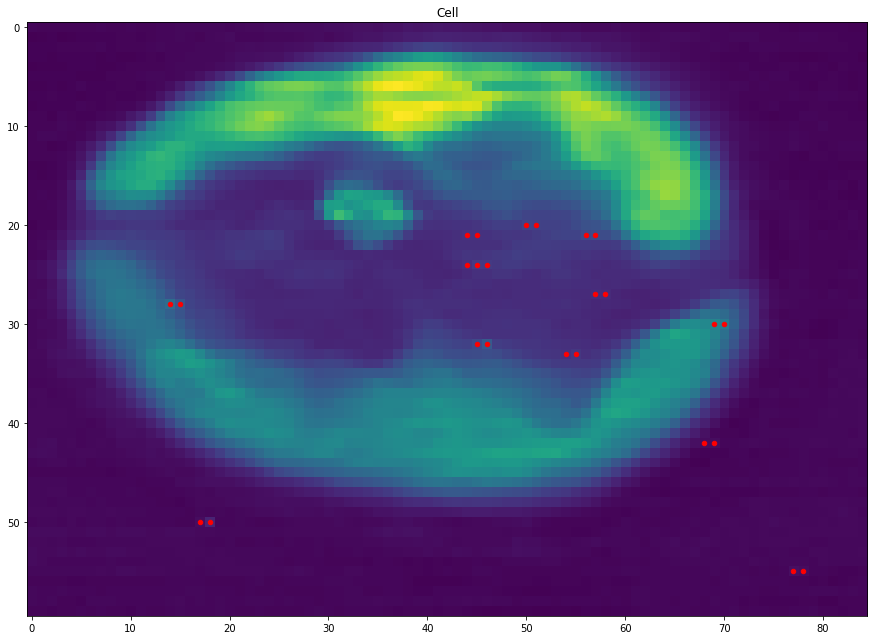

In [251]:
data = Data("./data/Cryptomonas.mat")

# (Darren A. Whitaker, Kevin Hayes)
th = 10 # th zda se zavisi na bunce :)))

diff = np.diff(data.data, axis=2)
M = np.median(diff, axis=2)
wide_M = np.repeat(M[:,:,np.newaxis], diff.shape[2], 2)
MAD = np.median(np.abs(diff-wide_M), axis=2)
Z = 0.6745 * (diff - wide_M) / np.repeat(MAD[:,:,np.newaxis], diff.shape[2], 2)
 # print(Z.shape) # shape check

pos = np.unique(np.vstack(np.where(np.abs(Z) > th)[:2]).T, axis=0)

x = [float(i[0]) for i in pos]
y = [float(i[1]) for i in pos]

plt.figure(figsize=(15,9))
plt.imshow(data.averages.T, zorder=1)
plt.scatter(x, y, color='red', zorder=2, s=20)
plt.axis('on')
plt.title("Cell")

plt.tight_layout()
plt.show()

## Zekvidistantnění

!! až po odstranění spiků -> prokládání polynomem by dopadlo zle

old x axis: [ 360.68895374  363.53295308  366.3759651  ... 3809.29272249 3811.09830523
 3812.90343241], average step: 2.257825035097029
new x axis: [ 361.  362.  363. ... 3809. 3810. 3811.], average step: 1.0


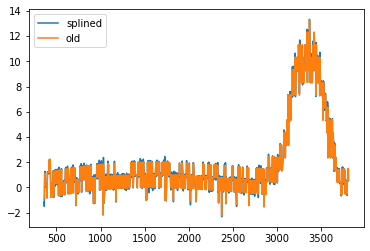

In [ ]:
data = Data("./data/Cryptomonas_final.mat")

spectrum_spline = si.CubicSpline(data.x_axis, data.pure_data.T, extrapolate=False)
step_size = 1
new_x = np.arange(np.ceil(data.x_axis[0]), np.floor(data.x_axis[-1]), step_size)
new_data = spectrum_spline(new_x)

print(f"old x axis: {data.x_axis}, average step: {np.mean(np.abs(np.diff(data.x_axis)))}")
print(f"new x axis: {new_x}, average step: {np.mean(np.abs(np.diff(new_x)))}")

plt.plot(new_x, new_data[:,0], label='splined')
plt.plot(data.x_axis, data.pure_data[0,:], label='old')
plt.legend()
plt.show()

## Maska

Maska vytvořená pomocí integrálu nad lineární křivkou propojující krajní body vybraného intervalu s CH vibracemi.
Dále nutná ještě úprava pro vyplnění masky. Ideálně nejprve odstranění okolního šumu a následně vytvoření konvexního obalu.

Lepší se dá udělat pomocí aplikace K-Means na 2 komponenty.

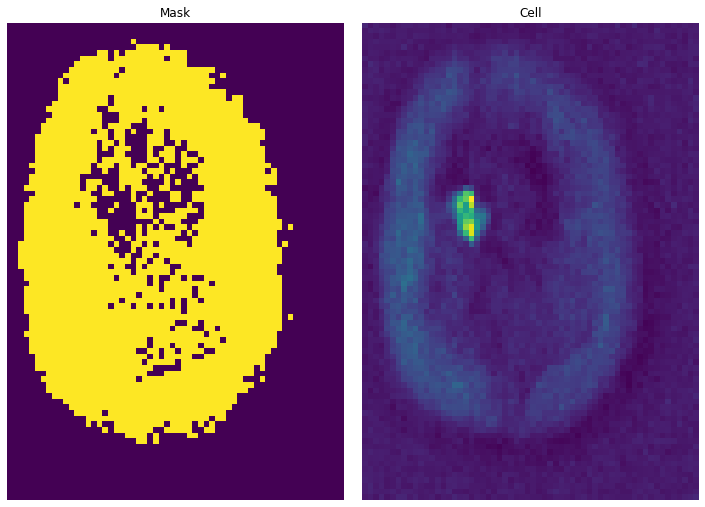

In [ ]:
# normalization
threshold = 400 # above -> cell

start = 2800
end = 3050
index_of_start = np.where(new_x==start)[0][0]
index_of_end = np.where(new_x==end)[0][0]
norm_data = new_data[index_of_start:index_of_end,:]

integral = np.sum(norm_data, axis=0)
ref = ((norm_data[0,:] + norm_data[-1,:]) / 2) * norm_data.shape[0]

diff = np.reshape(integral - ref, (data.data.shape[0], data.data.shape[1]), order='C') > threshold

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
plt.imshow(diff, interpolation='nearest')
plt.axis('off')
plt.title("Mask")

fig.add_subplot(1, 2, 2)

plt.imshow(data.averages, interpolation='nearest')
plt.axis('off')
plt.title("Cell")

plt.tight_layout()
plt.show()

## ICA

Rozklad na komponenty pomocí algoritmu FastICA. FastICA lze využít například i k detekci spiků nebo vytvoření masky.

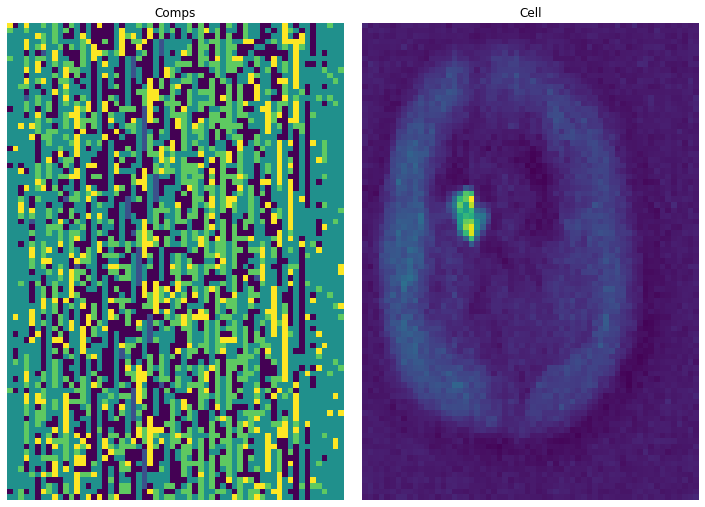

In [ ]:
import sklearn.decomposition as sd

n_comp = 5
pca = sd.FastICA(n_components=n_comp)
r = pca.fit(data.pure_data).transform(data.pure_data)
r = np.argmax(np.abs(r), axis=1)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
comp_im = np.reshape(r, (data.data.shape[0], data.data.shape[1]), order='F')
plt.imshow(comp_im, interpolation='nearest')
plt.axis('off')
plt.title("Comps")

fig.add_subplot(1, 2, 2)

plt.imshow(data.averages, interpolation='nearest')
plt.axis('off')
plt.title("Cell")

plt.tight_layout()
plt.show()

# PCA
normální klasická verze

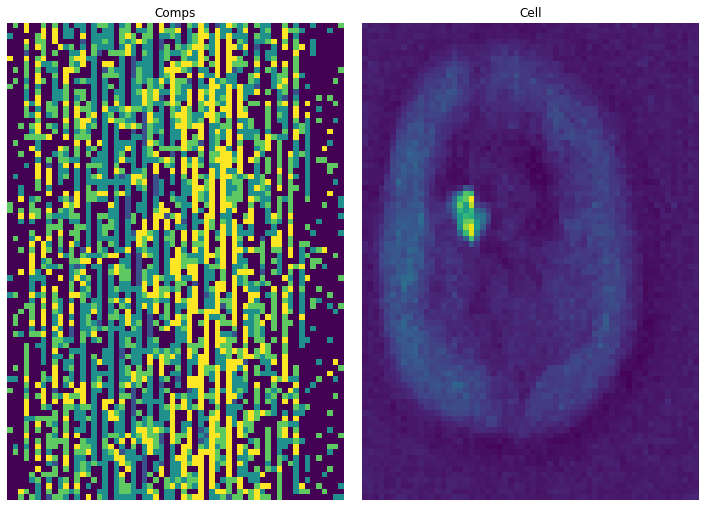

In [ ]:
import sklearn.decomposition as sd

n_comp = 5
pca = sd.PCA(n_components=n_comp, whiten=True)
r = pca.fit(data.pure_data).transform(data.pure_data)
r = np.argmax(np.abs(r), axis=1)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
comp_im = np.reshape(r, (data.data.shape[0], data.data.shape[1]), order='F')
plt.imshow(comp_im, interpolation='nearest')
plt.axis('off')
plt.title("Comps")

fig.add_subplot(1, 2, 2)

plt.imshow(data.averages, interpolation='nearest')
plt.axis('off')
plt.title("Cell")

plt.tight_layout()
plt.show()

# K-Means

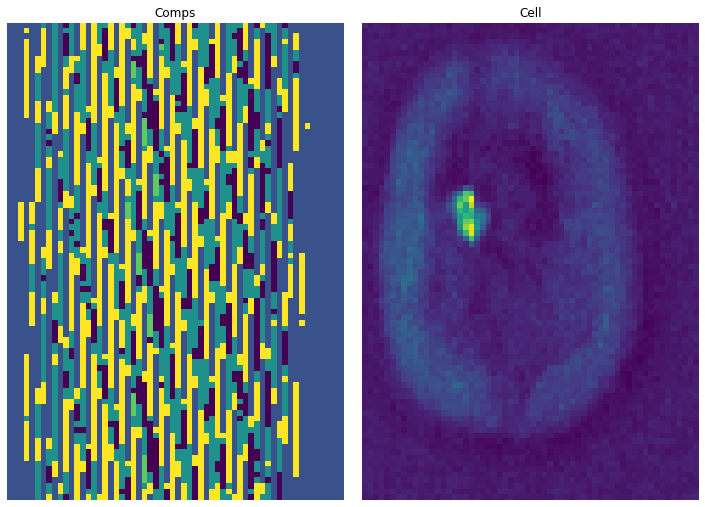

In [ ]:
from sklearn import cluster

n_comp = 5
clf = cluster.KMeans(n_clusters=n_comp)
clf.fit(data.pure_data)

r = clf.predict(data.pure_data)


fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
comp_im = np.reshape(r, (data.data.shape[0], data.data.shape[1]), order='F')
plt.imshow(comp_im, interpolation='nearest')
plt.axis('off')
plt.title("Comps")

fig.add_subplot(1, 2, 2)

plt.imshow(data.averages, interpolation='nearest')
plt.axis('off')
plt.title("Cell")

plt.tight_layout()
plt.show()

# K-Means Dropout

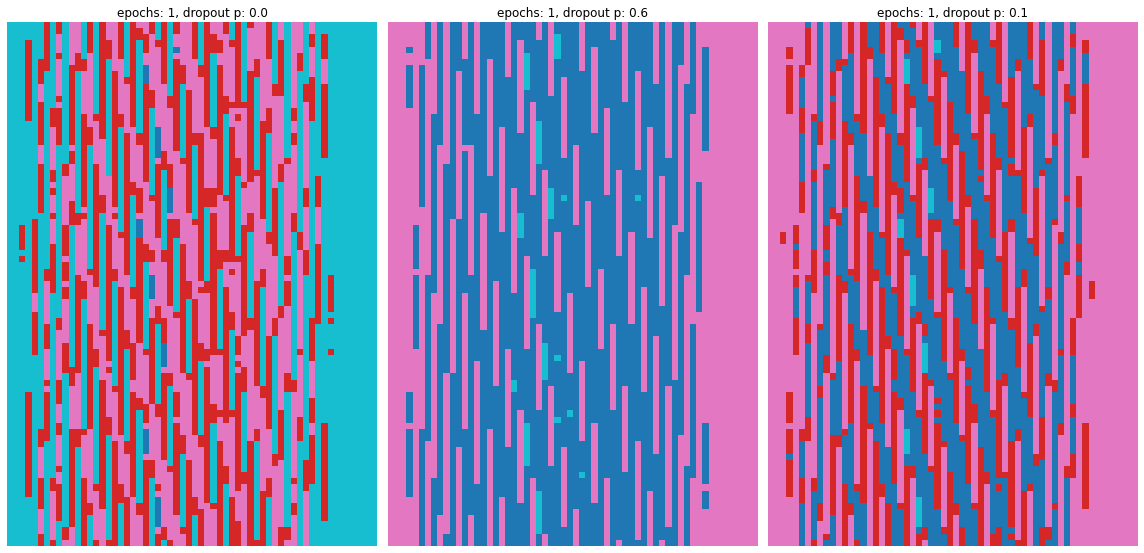

In [ ]:
from sklearn import cluster
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

data = Data("./data/Cryptomonas_final.mat")

n_comp = 4

# dropout_ps = [0.0, 0.1, 0.2, 0.5]
# epochs = [3, 5, 7, 10]
dropout_ps = [0.0, 0.6, 0.1]
epochs = [1]

# majority voting
def train(epochs, dropout_p):
    results = []
    for _ in range(epochs):
        clf = cluster.KMeans(n_clusters=n_comp)
        random_noise = np.random.uniform(size=data.pure_data.shape)
        new_data = np.where(random_noise > dropout_p, data.pure_data, 0)
        clf.fit(new_data)
        results.append(clf.predict(data.pure_data))
        # result = result + clf.predict(data.pure_data)
    # result = result / epochs
    result = np.stack(results, axis=0)
    return scipy.stats.mode(result, axis=0).mode[0]


plt.figure(figsize=(16, 16))

for ie, e in enumerate(epochs):
    for ip, p in enumerate(dropout_ps):
        plt.subplot(len(epochs), len(dropout_ps), len(dropout_ps) * ie + ip + 1)
        comp_im = np.reshape(train(e,p), (data.data.shape[0], data.data.shape[1]), order='F')
        plt.imshow(comp_im, interpolation='nearest', cmap='tab10')
        plt.axis('off')
        plt.title(f"epochs: {e}, dropout p: {p}")

plt.tight_layout()
plt.show()